<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task:-Shopee-binary-sentiment-classification" data-toc-modified-id="Task:-Shopee-binary-sentiment-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task: Shopee binary sentiment classification</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Convert-crash-files-(do-once)" data-toc-modified-id="Convert-crash-files-(do-once)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Convert crash files (do once)</a></span></li><li><span><a href="#Load-csv" data-toc-modified-id="Load-csv-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load csv</a></span></li></ul></li><li><span><a href="#Vietnamese-tokenization" data-toc-modified-id="Vietnamese-tokenization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vietnamese tokenization</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Pretokenization-(Vietnamese-word-tokenization)" data-toc-modified-id="Step-1:-Pretokenization-(Vietnamese-word-tokenization)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Step 1: Pretokenization (Vietnamese word tokenization)</a></span></li><li><span><a href="#Step-2:-Model's-tokenization" data-toc-modified-id="Step-2:-Model's-tokenization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Step 2: Model's tokenization</a></span></li></ul></li><li><span><a href="#Use-HuggingFace-Dataset-to-store-and-tokenize-corpus" data-toc-modified-id="Use-HuggingFace-Dataset-to-store-and-tokenize-corpus-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use HuggingFace Dataset to store and tokenize corpus</a></span></li><li><span><a href="#Define-dataset-dict-and-perform-train/val-split" data-toc-modified-id="Define-dataset-dict-and-perform-train/val-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define dataset dict and perform train/val split</a></span></li><li><span><a href="#Model-definition" data-toc-modified-id="Model-definition-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model definition</a></span><ul class="toc-item"><li><span><a href="#Classification-using-default-PhoBert" data-toc-modified-id="Classification-using-default-PhoBert-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Classification using default PhoBert</a></span></li><li><span><a href="#Define-helper-function-for-training" data-toc-modified-id="Define-helper-function-for-training-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Define helper function for training</a></span></li><li><span><a href="#Start-training" data-toc-modified-id="Start-training-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Start training</a></span></li></ul></li><li><span><a href="#Prediction-interpretation" data-toc-modified-id="Prediction-interpretation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction interpretation</a></span><ul class="toc-item"><li><span><a href="#Classification-report-and-confusion-matrix" data-toc-modified-id="Classification-report-and-confusion-matrix-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Classification report and confusion matrix</a></span></li><li><span><a href="#Most-confident-prediction:-right-vs-wrong" data-toc-modified-id="Most-confident-prediction:-right-vs-wrong-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Most confident prediction: right vs wrong</a></span></li></ul></li><li><span><a href="#Extract-hidden-states" data-toc-modified-id="Extract-hidden-states-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Extract hidden states</a></span><ul class="toc-item"><li><span><a href="#Redefine-dataset-dict" data-toc-modified-id="Redefine-dataset-dict-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Redefine dataset dict</a></span></li><li><span><a href="#Retrain-model" data-toc-modified-id="Retrain-model-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Retrain model</a></span></li><li><span><a href="#Find-neighbors" data-toc-modified-id="Find-neighbors-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Find neighbors</a></span></li></ul></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tqdm import tqdm
import re
import os 
from pathlib import Path
import numpy as np

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [4]:
from functools import partial

In [5]:
import matplotlib.pyplot as plt

In [6]:
from transformers.models.roberta.configuration_roberta import RobertaConfig
from transformers.models.roberta.modeling_roberta import RobertaModel # body only
#inherit this to load pretrained weight
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput

import torch


In [7]:
# !pip install underthesea

In [8]:
DATA_PATH = Path('data_crash')
RAW_PATH = Path('raw_crash')

In [9]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Task: Shopee binary sentiment classification

# Load data

## Convert crash files (do once)

In [10]:


# if not os.path.exists(DATA_PATH):
#     os.mkdir(DATA_PATH)

# ### Cleaning training file

# train = open(RAW_PATH/"train.crash").readlines()
# id_locations = []
# label_locations = []
# for idx, line in tqdm(enumerate(train)):
#     line = line.strip()
#     if line.startswith("train_"):
#         id_locations.append(idx)
#     elif line == "0" or line == "1":
#         label_locations.append(idx)
# data = []

# for id_loc, l_loc in tqdm(zip(id_locations, label_locations)):
#     line_id = train[id_loc].strip()
#     label = train[l_loc].strip()
#     text = re.sub('\s+', ' ', ' '.join(train[id_loc + 1: l_loc])).strip()[1:-1].strip()
#     data.append(f"{line_id}\t{text}\t{label}")

# with open(DATA_PATH/"train.csv", "wt") as f:
#     f.write("id\ttext\tlabel\n")
#     f.write("\n".join(data))

# ### Cleaning test file

# test = open(RAW_PATH/"test.crash").readlines()
# id_locations = []
# for idx, line in tqdm(enumerate(test)):
#     line = line.strip()
#     if line.startswith("test_"):
#         id_locations.append(idx)
# data = []

# for i, id_loc in tqdm(enumerate(id_locations)):
#     if i >= len(id_locations) - 1:
#         end = len(test)
#     else:
#         end = id_locations[i + 1]
#     line_id = test[id_loc].strip()
#     text = re.sub('\s+', ' ', ' '.join(test[id_loc + 1:end])).strip()[1:-1].strip()
#     data.append(f"{line_id}\t{text}")

# with open(DATA_PATH/"test.csv", "wt") as f:
#     f.write("id\ttext\n")
#     f.write("\n".join(data))

## Load csv

In [11]:
!ls {str(DATA_PATH)}

test.csv  train.csv


In [12]:
train_df = pd.read_csv(DATA_PATH/'train.csv',sep='\t').fillna("###")
test_df = pd.read_csv(DATA_PATH/'test.csv',sep='\t').fillna("###")

In [13]:
train_df[['text','label']].sample(20)

,text,label
1104,Ngon. Được nhiều ng thích,0
13556,Shop phục vụ kém Shop phục vụ kém Shop phục vụ...,1
8622,Chất lượng sản phẩm rất kémShop lừa đảo ng khá...,1
11294,Nhỏ nhưng có võ! kiểm soát dầu rất tốt,0
14689,chất liệu vải mỏng quá khuyên anh em nên mua l...,1
11571,Giao sai hang cho khach mat uy tin,1
16056,Rất tuyệt bà con ah. Sử dụng 3 lần. Da mặt mịn...,0
2829,Ko nhận đc áo do shop quên hàng những đã bù ti...,0
15159,Sp nói từ 6 đến 12 tháng mà mang ko vừa. Sp ch...,1
1304,"Màu rất là đẹp, chất phất cực kỳ pigmented luô...",0


In [14]:
print(train_df[['text','label']].sample(5).values)

[['San pham rat tot cam on shop Chất lượng sản phẩm tuyệt vời' 0]
 ['Shop phục vụ rất kémĐặt size 37, Shop gửi về 1 chiếc size 36, 1 chiếc size 37 K muốn trả hàng nên đặt thêm 1 đôi để Shop gửi bù và Shop chịu phí ship nhưng lại gửi đúng 1 đôi 2 chiếc size 36, và k chịu phi nên phải trả lại hàng Sau đó cũng k có ý kiến gì về trách nhiệm của Shop đối với đôi cũ'
  1]
 ['Tôi mua sản phẩm cách đây vài tháng do mới đầu ko để ý nhưg sau phát hiện ra đệm tai 1 bên cực mềm 1 bên thì cứng giống hệt lót của dòng m20x. Ko thể chấp nhận đc có cửa hàng ntnay trên tiki.'
  1]
 ['Bình cũ, rượu cũ, chỉ có nút chai là mới...ip chẳn thì mới hoàn toàn mới. Còn ip lẻ thì na ná cái cũ...'
  1]
 ['Rất đáng tiền..Shop phục vụ rất tốt' 0]]


In [15]:
print(test_df[['text']].sample(5).values)

[['Thích lắm luôn giày ren kem lấp lánh sang mà vẫn trẻ trung']
 ['Sao truyện của mình lại không có đai obi vậy......']
 ['Đóng gói sản phẩm rất đẹp và chắc chắn nhớ tới snack trẻ em hồi xưa']
 ['giày đẹp lắm shop ơi']
 ['Cam ơn shop nhìu nghen']]


# Vietnamese tokenization

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098136789/files/assets/nlpt_0401.png)

Jack Sparrow loves New York!


1. Normalization
    - set of operations you apply to a raw string to **make it “cleaner”**, e.g. stripping whitespace, rm accented chars, lowercasing, Unicode normalization (unify various ways to write the same character)

=> jack sparrow loves new york!

2. Pretokenization
    - splits a text into smaller objects (can be words) that **give an upper bound to what your tokens will be at the end of training; your final tokens will be parts of these smaller objects**
    - Sometimes splitting into 'words' is not always trivial (Chinese, Japanese, Korean). In this case, it might be best to not pretokenize the text and instead use a language-specific library for pretokenization.

=> ["jack", "sparrow", "loves", "new", "york", "!"]

3. Tokenizer model
    - tokenizer applies a **subword splitting model** on the words. This is the part of the pipeline that **needs to be trained on your corpus (or that has been trained if you are using a pretrained tokenizer)**
    -  to split the words into subwords to reduce the size of the vocabulary and try to reduce the number of out-of-vocabulary tokens
    - Several subword tokenization algorithms exist, including BPE, Unigram, and WordPiece
    
=> [jack, spa, rrow, loves, new, york, !]

NOTE: at this point we no longer have a list of strings but a list of integers (input IDs)

4. Postprocessing
    - some additional transformations can be applied on the list of tokens
    - e.g. adding special tokens at the beginning or the end
    - This is the last step, and the sequence of integers can be fed to the model
=> a BERT-style tokenizer would add classifications and separator tokens: [CLS, jack, spa, rrow, loves, new, york, !, SEP]
    

## Step 1: Pretokenization (Vietnamese word tokenization)

https://github.com/undertheseanlp/underthesea

```python
>>> from underthesea import word_tokenize
>>> sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'

>>> word_tokenize(sentence)
['Chàng trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']

>>> word_tokenize(sentence, format="text")
'Chàng_trai 9X Quảng_Trị khởi_nghiệp từ nấm sò'
```

In [16]:
from underthesea import word_tokenize, sent_tokenize

In [17]:
def apply_word_tokenize(sen,split_word=False):
    # optional step: fix the whitespace between words
    sen = " ".join(sen.split())
    sens = sent_tokenize(sen)
    
    # word tokenize
    tokenized_sen = []
    for sen in sens:
        tokenized_sen+=word_tokenize(sen,format='text' if not split_word else None)
    
    if not split_word:
        return ''.join(tokenized_sen)
    return ['_'.join(words.split(' ')) for words in tokenized_sen]
        

In [18]:
_tmp = 'Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


In [19]:
_tmp = 'Chất lượng sản phẩm tuyệt vời? Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '?', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


In [20]:
_tmp = 'Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
# print(apply_word_tokenize(_tmp,False))
print(apply_word_tokenize(_tmp,True))

['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '😌_😌', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']


Apply on the whole dataset

In [21]:
train_text = [apply_word_tokenize(s[0],True) for s in train_df[['text']].values]
train_label = train_df.label.values

In [22]:
test_text = [apply_word_tokenize(s[0],True) for s in test_df[['text']].values]

In [23]:
train_text[10:15]

[['Chất_lượng',
  'sản_phẩm',
  'tuyệt_vời',
  '.',
  'y',
  'hình',
  'chụp',
  '.',
  'đáng',
  'tiền'],
 ['Hjhj_shop',
  'giao',
  'hàng',
  'nhanh',
  'quá',
  '.',
  'Đẹp',
  'lắm',
  'ạ',
  'bé',
  'nhà',
  'm',
  'rất',
  'thích'],
 ['nhìn', 'đẹp', 'phết', 'nhỉ', '..'],
 ['Đóng_gói',
  'rất',
  'đẹp',
  '.',
  'Chất_lượng',
  'sản_phẩm',
  'rất',
  'tốt',
  'Chất_lượng',
  'sản_phẩm',
  'tuyệt_vời'],
 ['Săn', 'đc', 'với', 'giá', '11', 'k', '.', 'Toẹt', 'vời']]

## Step 2: Model's tokenization

To use pretrained language model such as BERT, GPT, Roberta... We need to tokenize words using the strategy in these models (BPE, wordpiece, ...)

Huggingface allows us to get the tokenizer corresponding to the model by the model name on their hub. In this notebook, we use PhoBERT-base (vinai/phobert-base).

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")# model name in huggingface's hub


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
def tokenizer_explain(inp,split_word):
    print('--- Tokenized results --- ')
    print(tokenizer(inp,is_split_into_words=split_word))
    print()
    tok = tokenizer.encode(inp,is_split_into_words=split_word)
    print('--- Results from tokenizer.convert_ids_to_tokens')
    print(tokenizer.convert_ids_to_tokens(tok))
    print()
    print('--- Results from tokenizer.decode --- ')
    print(tokenizer.decode(tok))
    print()


def two_step_tokenization_explain(inp,split_word=False):
    print('--- Raw sentence ---')
    print(inp)
    print()
    print('--- Pretokenization ---')
    tok = apply_word_tokenize(inp,split_word)
    print(tok)
    print()
    tokenizer_explain(tok,split_word)

In [26]:
_tmp = 'Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời, phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 4, 7079, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', ',', 'phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời, phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [27]:
_tmp = 'Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,split_word=False)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
Chất_lượng sản_phẩm tuyệt_vời .Phấn mịn , đóng_gói sản_phẩm rất đẹp và chắc_chắn

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 2586, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.@@', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời.Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [28]:
_tmp = 'Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 5, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời. Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



In [29]:
_tmp = 'Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn'
two_step_tokenization_explain(_tmp,split_word=True)

--- Raw sentence ---
Chất lượng sản phẩm tuyệt vời 😌😌. Phấn mịn, đóng gói sản phẩm rất đẹp và chắc chắn

--- Pretokenization ---
['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '😌_😌', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn']

--- Tokenized results --- 
{'input_ids': [0, 6869, 265, 1819, 3, 1751, 3, 5, 11459, 5451, 4, 8179, 265, 59, 258, 6, 994, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

--- Results from tokenizer.convert_ids_to_tokens
['<s>', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '<unk>', '_@@', '<unk>', '.', 'Phấn', 'mịn', ',', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', '</s>']

--- Results from tokenizer.decode --- 
<s> Chất_lượng sản_phẩm tuyệt_vời <unk> _<unk>. Phấn mịn, đóng_gói sản_phẩm rất đẹp và chắc_chắn </s>



# Use HuggingFace Dataset to store and tokenize corpus

In [30]:
from datasets import DatasetDict,Dataset

In [31]:
def tokenize_function(examples):
    # pad to model's allowed max length, which is max_sequence_length
    return tokenizer(examples["text"], padding="max_length", truncation=True,is_split_into_words=True)


In [32]:
train_dataset = Dataset.from_dict(
                        {'text': train_text[:4],
                        'label':train_label[:4],
                        }
                    )
# test_dataset = Dataset.from_dict(
#                         {'text': test_text,
#                         }
#                     )

In [33]:
train_dataset_tokenized = train_dataset.map(tokenize_function,batched=True,batch_size=2)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [34]:
train_dataset_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4
})

In [35]:
print(train_dataset_tokenized['text'])

[['Dung', 'dc', 'sp', 'tot', 'cam', 'on_shop', 'Đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', 'Chất_lượng', 'sản_phẩm', 'tuyệt_vời'], ['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', '.', 'Son', 'mịn', 'nhưng', 'khi', 'đánh', 'lên', 'không', 'như', 'màu', 'trên', 'ảnh'], ['Chất_lượng', 'sản_phẩm', 'tuyệt_vời', 'nhưng', 'k', 'có', 'hộp', 'k', 'có', 'dây', 'giày', 'đen', 'k', 'có', 'tất'], [':', '(', '(', 'Mình', 'hơi', 'thất_vọng', '1', 'chút', 'vì', 'mình', 'đã', 'kỳ_vọng', 'cuốn', 'sách', 'khá', 'nhiều', 'hi_vọng', 'nó', 'sẽ', 'nói', 'về', 'việc', 'học_tập', 'của', 'cách', 'sinh_viên', 'trường', 'Harvard', 'ra_sao', 'những', 'nỗ_lực', 'của', 'họ', 'như', 'thế_nào', '4', 'h', 'sáng', '?', 'tại_sao', 'họ', 'lại', 'phải', 'thức', 'dậy', 'vào', 'thời_khắc', 'đấy', '?', 'sau', 'đó', 'là', 'cả', 'một', 'câu_chuyện', 'ra_sao', '.', 'Cái', 'mình', 'thực_sự', 'cần', 'ở', 'đây', 'là', 'câu_chuyện', 'ẩn', 'dấu', 'trong', 'đó', 'để', 'tự', 'bản_thân', 'mỗi', 'người', 'cảm_nhận', 'và', 'đi', 'sâu

In [36]:
print(train_dataset_tokenized['input_ids'])

[[0, 3556, 1236, 1894, 36150, 2225, 1204, 2947, 1672, 20811, 54922, 55662, 1685, 265, 59, 258, 6, 994, 6869, 265, 1819, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 6869, 265, 1819, 5, 16332, 5451, 51, 26, 480, 72, 17, 42, 412, 34, 284, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Define dataset dict and perform train/val split

In [37]:
train_dataset = Dataset.from_dict(
                        {'text': train_text,
                        'label':train_label,
                        }
                    )
test_dataset = Dataset.from_dict(
                        {'text': test_text,
                        }
                    )

train_dataset_tokenized = train_dataset.map(tokenize_function,batched=True)
test_dataset_tokenized= test_dataset.map(tokenize_function,batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [38]:
seed_everything(42)
train_dataset_tokenized = train_dataset_tokenized.shuffle()

In [39]:
main_dataset_tokenized = DatasetDict()
main_dataset_tokenized['train'] = train_dataset_tokenized.select(range(int(train_dataset_tokenized.num_rows*0.8)))
main_dataset_tokenized['validation'] = train_dataset_tokenized.select(range(int(train_dataset_tokenized.num_rows*0.8),train_dataset_tokenized.num_rows))

In [40]:
main_dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12869
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3218
    })
})

In [41]:
pd.Series(main_dataset_tokenized['train']['label']).value_counts(normalize=True)

0    0.580154
1    0.419846
dtype: float64

In [42]:
pd.Series(main_dataset_tokenized['validation']['label']).value_counts(normalize=True)

0    0.563704
1    0.436296
dtype: float64

# Model definition

https://jalammar.github.io/illustrated-bert/

https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

## Classification using default PhoBert

In [43]:
# from transformers.models.roberta.configuration_roberta import RobertaConfig
# from transformers.models.roberta.modeling_roberta import RobertaModel 
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import Trainer, TrainingArguments
import torch

comet_ml is installed but `COMET_API_KEY` is not set.


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
def base_model_init(get_hidden=False):
    model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2,output_hidden_states=get_hidden)
    model = model.to(device)
    return model

## Define helper function for training

In [46]:
from sklearn.metrics import accuracy_score, f1_score
import gc

def compute_metrics(pred):
    # pred: EvalPrediction object 
    # (which is a named tuple with predictions and label_ids attributes)
    labels = pred.label_ids
    if isinstance(pred.predictions,tuple):
        preds = pred.predictions[0].argmax(-1)
    else:
        preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"f1": f1,"accuracy": acc}



def finetune(lr,bs,wd,epochs,ddict,tokenizer=tokenizer,o_dir = './outputs',logging=False,model_init=base_model_init):
    torch.cuda.empty_cache()
    gc.collect()

    if not logging:
        training_args = TrainingArguments(o_dir, 
                                 learning_rate=lr, 
                                 warmup_ratio=0.1, 
                                 lr_scheduler_type='cosine', 
                                 fp16=True,
                                do_train=True,
                                 do_eval=True,
                                 evaluation_strategy="epoch", 
                                 save_strategy="epoch",
                                 overwrite_output_dir=True,
                                gradient_accumulation_steps=1,
                                 per_device_train_batch_size=bs, 
                                 per_device_eval_batch_size=bs,
                                num_train_epochs=epochs, weight_decay=wd, report_to='none')
    else:
        training_args = TrainingArguments(o_dir, 
                                 learning_rate=lr, 
                                 warmup_ratio=0.1, 
                                 lr_scheduler_type='cosine', 
                                 fp16=True,
                                do_train=True,
                                 do_eval=True,
                                 evaluation_strategy="epoch", 
                                 save_strategy="epoch",
                                 overwrite_output_dir=True,
                                gradient_accumulation_steps=1,
                                 per_device_train_batch_size=bs, 
                                 per_device_eval_batch_size=bs,
                               logging_dir=os.path.join(o_dir, 'log'),
                                logging_steps = len(ddict["train"]) // bs,
                                num_train_epochs=epochs, weight_decay=wd)

    # instantiate trainer
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=ddict['train'],#.shard(200, 0),    # Only use subset of the dataset for a quick training. Remove shard for full training
        eval_dataset=ddict['validation'],#.shard(100, 0), # Only use subset of the dataset for a quick training. Remove shard for full training
#         data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    
    trainer.train()
    return trainer

## Start training

In [55]:
# lr = 1e-4
# bs=32
# wd=0.01
# epochs= 3
# o_dir = './default_phobert_finetuned_1'
# tmp = finetune(lr,bs,wd,epochs,ddict=main_dataset_tokenized,o_dir = o_dir)


# Epoch	Training Loss	Validation Loss	F1	Accuracy
# 1	No log	0.288897	0.907470	0.908950
# 2	0.298100	0.298636	0.897811	0.899627
# 3	0.180200	0.306182	0.909048	0.910193

PyTorch: setting up devices
loading configuration file config.json from cache at /home/quan1080/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_model.b

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.288897,0.907470,0.908950
2,0.298100,0.298636,0.897811,0.899627
3,0.180200,0.306182,0.909048,0.910193


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3218
  Batch size = 32
Saving model checkpoint to ./default_phobert_finetuned_1/checkpoint-403
Configuration saved in ./default_phobert_finetuned_1/checkpoint-403/config.json
Model weights saved in ./default_phobert_finetuned_1/checkpoint-403/pytorch_model.bin
tokenizer config file saved in ./default_phobert_finetuned_1/checkpoint-403/tokenizer_config.json
Special tokens file saved in ./default_phobert_finetuned_1/checkpoint-403/special_tokens_map.json
added tokens file saved in ./default_phobert_finetuned_1/checkpoint-403/added_tokens.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been i

In [49]:
lr = 1e-4
bs=6
wd=0.01
epochs= 3
o_dir = './default_phobert_finetuned_1_hiddenstate'
tmp = finetune(lr,bs,wd,epochs,ddict=main_dataset_tokenized,o_dir = o_dir)

loading configuration file config.json from cache at /home/quan1080/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_mod

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3218
  Batch size = 6


RuntimeError: CUDA out of memory. Tried to allocate 334.00 MiB (GPU 0; 11.77 GiB total capacity; 10.16 GiB already allocated; 239.88 MiB free; 10.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
!ls default_phobert_finetuned_1

checkpoint-1209  checkpoint-403  checkpoint-537  checkpoint-806


# Prediction interpretation

In [ ]:
model = base_model_init()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.from_pretrained('./default_phobert_finetuned_1/checkpoint-806')
model = model.to(device)

In [63]:
idx2str={0:"Positive",1:'Negative'}

In [64]:
from torch.nn.functional import cross_entropy

def label_int2str(row):
    return idx2str[row]

def forward_pass_with_label(batch,model=None):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy(),
           'predicted_probability': torch.nn.functional.softmax(output.logits.cpu(),dim=1).numpy()}

In [65]:
# Convert our dataset back to PyTorch tensors
main_dataset_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [66]:
# Compute loss values
main_dataset_tokenized["train"] = main_dataset_tokenized["train"].map(
    partial(forward_pass_with_label,model=model), batched=True, batch_size=16)
main_dataset_tokenized["validation"] = main_dataset_tokenized["validation"].map(
    partial(forward_pass_with_label,model=model), batched=True, batch_size=16)

  0%|          | 0/805 [00:00<?, ?ba/s]

  0%|          | 0/202 [00:00<?, ?ba/s]

In [67]:
main_dataset_tokenized.set_format("pandas")
cols = ["text", "label", "predicted_label", 'predicted_probability',"loss"]
df_val = main_dataset_tokenized["validation"][:][cols]
df_val["label_str"] = df_val["label"].apply(lambda x: idx2str[x])
df_val["predicted_label_str"] = (df_val["predicted_label"]
                              .apply(lambda x: idx2str[x]))

In [68]:
df_trn = main_dataset_tokenized["train"][:][cols]
df_trn["label_str"] = df_trn["label"].apply(lambda x: idx2str[x])
df_trn["predicted_label_str"] = (df_trn["predicted_label"]
                              .apply(lambda x: idx2str[x]))

In [69]:
df_trn.shape,df_val.shape

((12869, 7), (3218, 7))

In [70]:
df_val.head()

,text,label,predicted_label,predicted_probability,loss,label_str,predicted_label_str
0,"[Thông_tin, chi_tiết, trên, web, là, sản_xuất,...",1,1,"[0.0779537, 0.92204636]",0.081160,Negative,Negative
1,"[Đồng_hồ, dây_đeo, ọp_ẹp, ., Tất_nilon, rẻ_tiề...",1,1,"[0.04499709, 0.9550029]",0.046041,Negative,Negative
2,"[Shop, de, thương, nhiet, tình, sẽ, ủng, hô, l...",0,0,"[0.99736834, 0.0026315863]",0.002635,Positive,Positive
3,"[Nhìn, k, chắc_chắn, lắm]",0,0,"[0.5285818, 0.47141826]",0.637558,Positive,Positive
4,"[Chất_lượng, sản_phẩm, rất, kém, ., Rách, lỗi,...",1,1,"[0.022633858, 0.9773662]",0.022894,Negative,Negative


In [71]:
df_trn.head()

,text,label,predicted_label,predicted_probability,loss,label_str,predicted_label_str
0,"[Cầm, khá, chắc_tay, ., Trục, uốn, to, đúng, q...",0,0,"[0.997373, 0.0026270347]",0.002630,Positive,Positive
1,"[3G, còn, tùy, lúc_nào, và, khi, nào, và, ở, đ...",0,0,"[0.99603903, 0.0039609983]",0.003969,Positive,Positive
2,"[Đóng_gói, sản_phẩm, rất, chắc_chắn, ., Thời_g...",0,0,"[0.99715614, 0.0028438682]",0.002848,Positive,Positive
3,"[mình, xài, em, này, bị, đứng, máy, hoài, à]",1,1,"[0.13099755, 0.8690025]",0.140409,Negative,Negative
4,"[Chết, $]",1,1,"[0.09323443, 0.9067656]",0.097871,Negative,Negative


## Classification report and confusion matrix

In [75]:
print(classification_report(df_trn.label.values,df_trn.predicted_label.values,target_names = ['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.96      0.96      0.96      7466
    Negative       0.94      0.95      0.94      5403

    accuracy                           0.95     12869
   macro avg       0.95      0.95      0.95     12869
weighted avg       0.95      0.95      0.95     12869



In [77]:
print(classification_report(df_val.label.values,df_val.predicted_label.values,target_names = ['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.91      0.92      0.91      1814
    Negative       0.89      0.88      0.88      1404

    accuracy                           0.90      3218
   macro avg       0.90      0.90      0.90      3218
weighted avg       0.90      0.90      0.90      3218



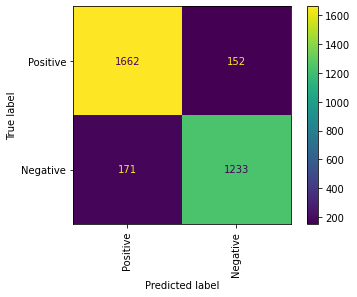

In [82]:
# fig,ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df_val.label.values,df_val.predicted_label.values,
                                        display_labels=['Positive','Negative'],xticks_rotation='vertical')

## Most confident prediction: right vs wrong

In [83]:
def _get_prob_match(row):
    l = row['label']
    prob = row['predicted_probability']
    return prob[l]
def _get_prob_mismatch(row):
    prob = row['predicted_probability']
    return np.max(prob)

In [84]:
df_val['correct_confidence'] = df_val.loc[df_val.label==df_val.predicted_label].apply(_get_prob_match,axis=1)

In [85]:
df_val['incorrect_confidence'] = df_val.loc[df_val.label!=df_val.predicted_label].apply(_get_prob_mismatch,axis=1)

In [86]:
def analyze_correct_pred(df,cols=['text','label_str','correct_confidence'],ascending=False,top_n=5):
    raw_tmp = df.sort_values('correct_confidence',ascending=ascending)[cols].head(top_n).values
    for tmp in raw_tmp:
        print(' | '.join(tmp[0]))
        print(tmp[1:])
        print('-'*100)
def analyze_incorrect_pred(df,cols=['text','label_str','predicted_label_str','incorrect_confidence'],ascending=False,top_n=5):
    raw_tmp = df.sort_values('incorrect_confidence',ascending=ascending)[cols].head(top_n).values
    for tmp in raw_tmp:
        print(' | '.join(tmp[0]))
        print(f'True label: {tmp[1]}, but predict {tmp[2]}, with confidence {tmp[3]}')
        print('-'*100)

In [89]:
analyze_correct_pred(df_val,ascending=True,top_n=20)

Mua | ao | mua | bo_shop | giao | ao | mua | doi | LAM | sao | DANH_Giá | the | nao | day
['Negative' 0.5087628960609436]
----------------------------------------------------------------------------------------------------
Bông | mềm | hơn | nhưng | cũng | mỏng | hơn | đợt | trước | dùng
['Positive' 0.5093692541122437]
----------------------------------------------------------------------------------------------------
Ghi | date | T2 | / | 2019 | nên | mới | đặt_hàng | đến | 5 | gói | nhận | hàng | thì | T1 | / | 2019 | thực_phẩm | cho | bé | nên | bán | đúng_hạn | sử_dụng | giới_thiệu | để | khách | tin_tưởng | & | quyết_định | mua | hàng
['Negative' 0.5200026035308838]
----------------------------------------------------------------------------------------------------
Pin | tụt | nhanh | nhưng | không | bị | sập | nguồn
['Positive' 0.5242894887924194]
----------------------------------------------------------------------------------------------------
Mở_ra | có | mỗi | vỏ | ko | thấy

In [90]:
analyze_incorrect_pred(df_val,ascending=False,top_n=20)

. | Hàng | rất | đẹp | <3 | !
True label: Negative, but predict Positive, with confidence 0.9974151849746704
----------------------------------------------------------------------------------------------------
Tam | duoc | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn
True label: Negative, but predict Positive, with confidence 0.997407853603363
----------------------------------------------------------------------------------------------------
Chất_lượng | sản_phẩm | tuyệt_vời | Đóng_gói | sản_phẩm | rất | đẹp | và | chắc_chắn | Shop | phục_vụ | rất | tốt | Thời_gian | giao | hàng | chậm | Rất | đáng | tiền | Thời_gian | giao | hàng | chậm
True label: Negative, but predict Positive, with confidence 0.997378945350647
----------------------------------------------------------------------------------------------------
Chất_lượng | sản_phẩm | tuyệt_vời | nhưng | toàn | chữ | Trung_Quốc | .
True label: Negative, but predict Positive, wit

In [91]:
analyze_incorrect_pred(df_val,ascending=True,top_n=20)

Khẩu_vị | của | mình | thì | hơi | nhạt | và | thiếu | cay | :)
True label: Positive, but predict Negative, with confidence 0.5006212592124939
----------------------------------------------------------------------------------------------------
Đóng_gói | đẹp | . | Nhưng | pin | ko | bền | . | Nạp | sạc | dự_phòng | cả | đêm | mới | đầy | mà | Sạc | chỉ | dc | 1 | lần | là | hết | . | - | _ | -
True label: Positive, but predict Negative, with confidence 0.5072213411331177
----------------------------------------------------------------------------------------------------
Chất_lượng | của | sản_phẩm | phù_hợp | với | giá | tiền | . | Có_thể | hãng | cần | nghiên_cứu | sao | cho | cục | sạc | ít | nóng | trong | quá_trình | sạc | vì | hiện_nay | khi | sạc | cục | sạc | rất | nóng | nên | tâm_lý | người | sử_dụng | sợ | nó | cháy | nổ | .
True label: Negative, but predict Positive, with confidence 0.5155402421951294
--------------------------------------------------------------------------

# Extract hidden states

In [65]:
# PHO_PATH = Path('/home/quan1080/kwon/PhoBERT_base_transformers')

In [75]:
# class RobertaForHiddenState(RobertaPreTrainedModel):
#     # make sure standard XLM-R are used
#     config_class = RobertaConfig

#     def __init__(self, config):
#         super().__init__(config)
#         self.num_labels = config.num_labels # TODO: change it to ner+chunk output
#         # Load model body
#         # add_polling_layer to False
#         #    to ensure all hidden states are returned 
#         #    and not only the one associated with the [CLS] token.
#         self.roberta = RobertaModel(config, add_pooling_layer=False)
#         # Set up token classification head
#         self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)
#         # Load and initialize weights from RobertaPretrainedModel
#         self.init_weights()

#     def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
#                 labels=None, **kwargs):
#         # Use model body to get encoder representations
#         # the only ones we need for now are input_ids and attention_mask
#         outputs = self.roberta(input_ids, attention_mask=attention_mask,
#                                token_type_ids=token_type_ids, **kwargs)
        
#         hidden_states = outputs['hidden_states'] # tuples with len 13 (number of layer/block)
#         # each with shape: (bs,seq_len,hidden_size_len), e.g. for phobert: (bs,256, 768)
#         # Note: hidden_size_len = embedding_size
#         last_hidden_state = hidden_states[-1][:,0] # (bs,768)

#         logits = self.dropout(last_hidden_state)
#         logits = self.classifier(logits) # (bs,num_labels)
        
    
# #         # Calculate losses
#         loss = None
#         if labels is not None: # labels size: (bs,seq_len) # TODO: change loss for dual prediction
#             loss_fct = torch.nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#         # Return model output object
#         return SequenceClassifierOutput(loss=loss, logits=logits,
#                                      hidden_states=outputs.hidden_states,
#                                      attentions=outputs.attentions)


In [76]:
# def custom_model_init():
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     config = AutoConfig.from_pretrained(
#         PHO_PATH/'config.json',
#         output_hidden_states=True,
#         num_labels=2,
#     )

#     model = RobertaForHiddenState.from_pretrained(PHO_PATH/'model.bin',config=config).to(device)
#     return model

## Redefine dataset dict

In [77]:
seed_everything(42)

In [47]:
# train_dataset = Dataset.from_dict(
#                         {'text': train_text,
#                         'label':train_label,
#                         }
#                     )
# test_dataset = Dataset.from_dict(
#                         {'text': test_text,
#                         }
#                     )

# train_dataset_tokenized = train_dataset.map(tokenize_function,batched=True)
# test_dataset_tokenized= test_dataset.map(tokenize_function,batched=True)

# train_dataset_tokenized = train_dataset_tokenized.shuffle()
train_sample = train_dataset_tokenized.shuffle().select(range(int(train_dataset_tokenized.num_rows*0.1)))
sample_dataset_tokenized = DatasetDict()
sample_dataset_tokenized['train'] = train_sample.select(range(int(train_sample.num_rows*0.8)))
sample_dataset_tokenized['validation'] = train_sample.select(range(int(train_sample.num_rows*0.8),train_sample.num_rows))

In [48]:
sample_dataset_tokenized['train'].num_rows,sample_dataset_tokenized['validation'].num_rows

(1286, 322)

## Retrain model

In [51]:
lr = 1e-4
bs=6
wd=0.01
epochs= 3
o_dir = './default_phobert_finetuned_1_hiddenstate'
tmp = finetune(lr,bs,wd,epochs,ddict=sample_dataset_tokenized,o_dir = o_dir,model_init=partial(base_model_init,get_hidden=True))

loading configuration file config.json from cache at /home/quan1080/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "PhobertTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file pytorch_mod

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.302326,0.886299,0.894410
2,No log,0.395047,0.892988,0.900621
3,0.357600,0.377929,0.908195,0.913043


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 322
  Batch size = 6
Saving model checkpoint to ./default_phobert_finetuned_1_hiddenstate/checkpoint-215
Configuration saved in ./default_phobert_finetuned_1_hiddenstate/checkpoint-215/config.json
Model weights saved in ./default_phobert_finetuned_1_hiddenstate/checkpoint-215/pytorch_model.bin
tokenizer config file saved in ./default_phobert_finetuned_1_hiddenstate/checkpoint-215/tokenizer_config.json
Special tokens file saved in ./default_phobert_finetuned_1_hiddenstate/checkpoint-215/special_tokens_map.json
added tokens file saved in ./default_phobert_finetuned_1_hiddenstate/checkpoint-215/added_tokens.json
The following columns in the evaluation set don't have a corresponding 

In [54]:
model = tmp.model

In [80]:
# model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base",config=config)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.from_pretrained('./default_phobert_finetuned_1_hiddenstate/checkpoint-645')
# model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.3.attention.self.key.bias', 'roberta.encoder.layer.3.attention.output.dense.weight', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.11.attention.self.query.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'roberta.encoder.layer.6.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.5.attention.self.key.bias', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.8.output.LayerNorm.weight', 'roberta.encoder.layer.3.intermediate.dense.weight', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'roberta.encod

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['encoder.layer.11.attention.self.query.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.4.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.1.output.dense.weight', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.2.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.4.attention.output.LayerNorm.weight', 'encoder.layer.11.output.dense.weight', 'encoder.layer.5.attention.self.query.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.attention.self.key.weight', 

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at ./default_phobert_finetuned_1/checkpoint-806 were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.3.attention.self.key.bias', 'roberta.encoder.layer.3.attention.output.dense.weight', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.11.attention.self.query.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'roberta.encoder.layer.6.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.7.attention.self.key.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.5.attention.self.key.bias', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.8.output.LayerNorm.weight', 'roberta.encoder.layer

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./default_phobert_finetuned_1/checkpoint-806 and are newly initialized: ['encoder.layer.11.attention.self.query.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.4.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.1.output.dense.weight', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.2.output.dense.weight', 'encoder.layer.11.attention.self.value.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.4.attention.output.LayerNorm.weight', 'encoder.layer.11.output.dense.weight', 'encoder.layer.5.attention.self.query.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.7.attention.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.at

In [55]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).hidden_states[-1]
    # Return vector for [CLS] token
    
    # "hidden_state": the new transformer datasetdict will have
    # an extra column called 'hidden_state'
    # also, must return a numpy array/python object for datasetdict
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [56]:
sample_dataset_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

sample_dataset_tokenized['validation'] = sample_dataset_tokenized['validation'].map(extract_hidden_states, batched=True,batch_size=2)

  0%|          | 0/161 [00:00<?, ?ba/s]

In [59]:
sample_dataset_tokenized['validation']['hidden_state'].shape

torch.Size([322, 768])

## Find neighbors

In [63]:
data = sample_dataset_tokenized['validation']['hidden_state'].cpu().numpy()

In [62]:
from sklearn.neighbors import NearestNeighbors

In [64]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(data)

NearestNeighbors()

In [68]:
sample_dataset_tokenized['validation']['label'][0]

tensor(0)

In [90]:
def concat_str(inp):
    return ' '.join(inp)
def show_neighbors(neigh,idx,data=data,metadata=sample_dataset_tokenized['validation'],n_neighbors=5):
    print(f"Sentence: {concat_str(metadata['text'][idx])}\nLabel: {metadata['label'][idx]}")
    distances,nbors = neigh.kneighbors([data[idx]])

    print('\nNeighbors: ')
    for d,n_idx in zip(distances[0],nbors[0]):
        print(f"\t{concat_str(metadata['text'][n_idx])}, d={d:.3f}, label={metadata['label'][n_idx]}")

In [101]:
show_neighbors(neigh,9)

Sentence: Rất đáng tiền
Label: 0

Neighbors: 
	Rất đáng tiền, d=0.000, label=0
	Giày rất đẹp êm ., d=0.724, label=0
	Shop làm_việc OK lắm, d=0.870, label=0
	Đồng_hồ đẹp, d=0.885, label=0
	Mẫu_mã đẹp hy_vọng chất_lượng tốt ., d=0.902, label=0


TODO:
- concat last 4 hidden states for better sentence presentation
- run on 3090 for better results?
- raw output from phobert and check representation => comparison